Android gameplay footage (Hill Climb Racing) via scrcpy → virtual cam → Python



# Running the model

In [1]:
import cv2
import subprocess
import time
import torch
import numpy as np
from IPython.core.display_functions import clear_output
from PIL import Image


In [2]:
# === CONFIG ===
ACCEL_POS = (200, 850, 240, 850, 500)  #(x1, y1, x2, y2)
BRAKE_POS = (2115, 850, 2200, 850, 500)  #(x1, y1, x2, y2)
VIDEO_DEVICE = '/dev/video10'
HOLD_DURATION_MS = 10_000  # 10 seconds (long enough to cover many steps)
TAP_DURATION_MS = 1  # 10 seconds (long enough to cover many steps)

....

In [3]:
# === HELPERS ===
def start_hold(x, y, duration_ms=HOLD_DURATION_MS):
    """Start a long press in background (non-blocking)"""
    return subprocess.Popen([
        'adb', 'shell', 'input', 'swipe',
        str(x), str(y), str(x), str(y), str(duration_ms)
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


def stop_hold(proc):
    """Gracefully stop a running hold"""
    if proc is not None:
        proc.terminate()
        try:
            proc.wait(timeout=0.1)
        except subprocess.TimeoutExpired:
            proc.kill()


def get_action_from_model(frame):
    """
    Replace this with your PyTorch model.
    Must return one of: "accel", "brake", "none"
    """
    # Placeholder: random action (replace with real inference)
    time.sleep(0.02)  # Simulate model latency (~20ms)
    return np.random.choice(["accel", "brake", "none"])


def get_frame(cap):
    """Grab single frame from video device"""
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Failed to read frame")
    return frame


def resize_img(frame, width=84):
    """Resize frame to given width, preserving aspect ratio (height auto-scaled)"""
    h, w = frame.shape[:2]
    new_w = width
    new_h = int(h * (new_w / w))
    resized = cv2.resize(frame, (new_w, new_h))
    return resized


def ocr_distance(frame):
    """Extract distance from frame via OCR. Return float distance in meters."""
    h, w = frame.shape[:2]

    # ADJUST THESE CROP COORDINATES TO YOUR SCREEN
    x1, x2 = 1800, 2200
    y1, y2 = 20, 60

    # Fix bounds
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        print("OCR: Invalid crop region")
        return 0.0

    roi = frame[y1:y2, x1:x2]

    # Only show if valid
    if roi.size > 0:
        cv2.imshow("OCR Region", roi)
        cv2.waitKey(1)

    # TODO: Add OCR here later
    return 0.0

## stream the screen though adb

In [4]:
import subprocess
import time
import cv2

# Start scrcpy in background
scrcpy_proc = subprocess.Popen([
    'scrcpy', f'--v4l2-sink={VIDEO_DEVICE}',
    '--no-window', '--max-size', '720', '--stay-awake'
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

time.sleep(2)

cap = cv2.VideoCapture(VIDEO_DEVICE)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open {VIDEO_DEVICE}")

## OCR distance

### test: ocr distance from screen using `easyocr`

In [5]:
from PIL import Image
import easyocr

reader = easyocr.Reader(['en'], gpu=True)


def ocr_distance(frame):
    """Extract distance from frame via OCR. Return float distance in meters."""
    h, w = frame.shape[:2]

    # ADJUST THESE CROP COORDINATES TO YOUR SCREEN
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    # Fix bounds
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocessing for better OCR:
    # Preprocessing for better OCR:
    # Preprocessing for better OCR:
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Display (for debugging in notebook)
    display(Image.fromarray(thresh, 'L'))

    # Run EasyOCR on preprocessed image
    try:
        result = reader.readtext(thresh, detail=0, allowlist='0123456789m')
        if result:
            text = result[0].strip().lower().replace('m', '')
            if text.isdigit():
                print("OCR Distance: ", text)
                return int(text)
    except Exception as e:
        pass
    return 0

# while True:
#     clear_output()
#
#     # # ret, frame = cap.read()
#     frame = get_frame(cap)
#     # rframe = resize_img(frame)
#     # Image.fromarray(frame)
#     # Image.fromarray(rframe)
#     ocr_distance(frame)
#     # len(frame)
#     time.sleep(50 / 1000)


KeyboardInterrupt: 

### test: ocr using PaddleOCR

In [5]:
from paddleocr import PaddleOCR

ocr_engine = PaddleOCR(use_angle_cls=False, lang='en')

/home/ezio4df/projects/rl-hill-climb-racer/.venv/lib/python3.13/site-packages/paddlex/inference/pipelines/paddleocr_vl/pipeline.py:306: SyntaxWarning: invalid escape sequence '\('
  result_str.replace("\(", " $ ")
/tmp/ipykernel_62911/63081285.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_engine = PaddleOCR(use_angle_cls=False, lang='en')
which: no ccache in (/home/ezio4df/projects/rl-hill-climb-racer/.venv/bin:/home/ezio4df/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsight_compute:/opt/cuda/nsight_systems/bin:/var/lib/flatpak/exports/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/opt/rocm/bin)
/home/ezio4df/projects/rl-hill-climb-racer/.venv/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source fil

In [11]:
# ADD ONCE AT TOP (after imports)
from paddleocr import PaddleOCR

ocr_engine = PaddleOCR(use_angle_cls=False, lang='en')


def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Correct call: .ocr(), NOT callable
    result = ocr_engine.ocr(roi, cls=False)
    if result and len(result[0]) > 0:
        text = result[0][0][1][0]
        num_str = ''.join(filter(str.isdigit, text))
        if num_str:
            return int(num_str)
    return 0

# while True:
#     clear_output()
#
#     # # ret, frame = cap.read()
#     frame = get_frame(cap)
#     # rframe = resize_img(frame)
#     # Image.fromarray(frame)
#     # Image.fromarray(rframe)
#     ocr_distance(frame)
#     # len(frame)
#     time.sleep(500 / 1000)

/tmp/ipykernel_62911/2964085493.py:23: DeprecationWarning: Please use `predict` instead.
  result = ocr_engine.ocr(roi, cls=False)


TypeError: PaddleOCR.predict() got an unexpected keyword argument 'cls'

### test: ocr using Tesseract-OCR

In [26]:
# ADD ONCE AT TOP (after imports)
import pytesseract

In [36]:

def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocess for Tesseract: B&W, high contrast
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)
    display(Image.fromarray(thresh))

    # Run Tesseract: only digits and 'm'
    text = pytesseract.image_to_string(
        thresh,
        config='--psm 8 --oem 0 -c tessedit_char_whitelist=0123456789m'
    )
    num_str = ''.join(filter(str.isdigit, text))
    return int(num_str) if num_str else 0


while True:
    clear_output()

    # # ret, frame = cap.read()
    frame = get_frame(cap)
    # rframe = resize_img(frame)
    # Image.fromarray(frame)
    # Image.fromarray(rframe)
    print(ocr_distance(frame))
    # len(frame)
    time.sleep(500 / 1000)
    break

555


### test: ocr using template

In [14]:
# load 0-9 character templates, for ocr'ing the distance from screen

import os


def load_chr_templates():
    templates = {}
    for i in range(10):
        path = f"assets/chr_{i}.png"
        if os.path.exists(path):
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # loads BGRA
            templates[str(i)] = img
    return templates


chr_templates = load_chr_templates()

In [23]:
from PIL import Image


def ocr_distance(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Convert ROI to grayscale (once)
    # roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY).astype(np.float32)
    roi_gray = roi

    display(Image.fromarray(roi_gray))

    text = ""
    pos = 0
    while pos < roi_gray.shape[1]:
        best_char = None
        min_diff = float('inf')
        for char, tmpl in chr_templates.items():
            if tmpl is None:
                continue
            h_t, w_t = tmpl.shape[:2]
            if pos + w_t > roi_gray.shape[1] or h_t != roi_gray.shape[0]:
                continue

            # Extract patch (no resize)
            patch = roi_gray[:, pos:pos + w_t]
            if patch.shape != (h_t, w_t):
                continue

            # Extract alpha (opacity) — ignore if < 1/255
            alpha = tmpl[:, :, 3].astype(np.float32) / 255.0
            mask = alpha > 0.01  # treat near-transparent as transparent

            if not np.any(mask):
                continue

            # Template grayscale
            tmpl_gray = cv2.cvtColor(tmpl[:, :, :3], cv2.COLOR_BGR2GRAY).astype(np.float32)

            # Compute absolute difference only on opaque pixels
            diff = np.abs(patch - tmpl_gray) * mask
            total_diff = np.sum(diff) / np.sum(mask)  # normalize by valid pixels

            if total_diff < min_diff and total_diff < 30.0:  # threshold tuned
                min_diff = total_diff
                best_char = char

        if best_char:
            text += best_char
            pos += chr_templates[best_char].shape[1]  # advance by digit width
        else:
            pos += 1  # move 1px if no match

    print(text)
    return int(text) if text.isdigit() else 0


frame = get_frame(cap)
ocr_distance(frame)

0

### Train custom model for accurate ocr of the distance!

In [5]:
import os
import hashlib
from PIL import Image


def save_unique_image(img: Image.Image, folder="assets/extracts"):
    os.makedirs(folder, exist_ok=True)

    # Compute hash of the image
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()
    filepath = os.path.join(folder, f"{img_hash}.png")

    # Save only if not exists
    if not os.path.exists(filepath):
        img.save(filepath)
        return True
    return False

In [6]:
def get_distance_img(frame):
    h, w = frame.shape[:2]
    x1, y1 = 240, 24
    x2, y2 = x1 + 70, y1 + 19

    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    if x2 <= x1 or y2 <= y1:
        return 0

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return 0

    # Preprocess for Tesseract: B&W, high contrast
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)

    # display(Image.fromarray(thresh))
    return thresh

In [10]:
frame = get_frame(cap)

# while True:
    clear_output()
    start_iter = time.perf_counter()

    distance_img = Image.fromarray(get_distance_img(frame))
    did_save = save_unique_image(distance_img)

    display(distance_img)
    iter_time = time.perf_counter() - start_iter
    print(f"\r took: {iter_time * 1000:.1f} ms | {'saved!' if did_save else ''}", end="")



KeyboardInterrupt: 

In [9]:
def split_digits(roi):
    """
    Split a distance ROI (e.g., '123m') into individual digit images.
    Assumes white digits on black background (invert if needed).
    Returns list of cropped digit images (left to right).
    """
    # Ensure binary: white digits on black background
    if len(roi.shape) == 3:
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        gray = roi.copy()
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)  # white text → white foreground

    # Find contours (each digit is a blob)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes and sort left-to-right
    digit_bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Filter noise (optional)
        if w > 3 and h > 5:  # min digit size
            digit_bboxes.append((x, y, w, h))

    digit_bboxes = sorted(digit_bboxes, key=lambda b: b[0])  # sort by x

    # Crop digits
    digits = []
    for (x, y, w, h) in digit_bboxes:
        digit = roi[y:y+h, x:x+w]
        digits.append(digit)

    return digits

def scale_pil_image(img: Image.Image, scale: int) -> Image.Image:
    """Scale up a PIL image by integer factor using nearest neighbor."""
    return img.resize((img.width * scale, img.height * scale), Image.NEAREST)

Random image: 1027m-01.png


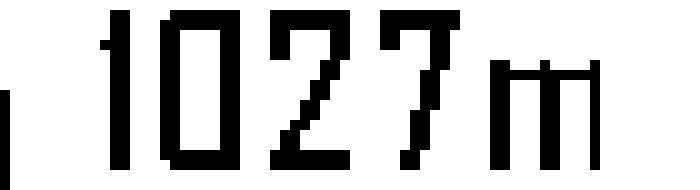

Split digits:


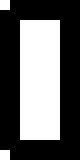

Digit 0: shape (16, 8)


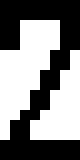

Digit 1: shape (16, 8)


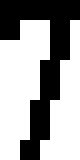

Digit 2: shape (16, 8)


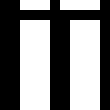

Digit 3: shape (11, 11)


In [51]:
import os
import random
from IPython.display import display
from PIL import Image
import cv2

# Get a random labeled image
labeled_dir = "assets/labeled"
labeled_images = [f for f in os.listdir(labeled_dir) if f.endswith('.png')]
if not labeled_images:
    raise FileNotFoundError("No labeled images found!")

random_img = random.choice(labeled_images)
img_path = os.path.join(labeled_dir, random_img)
print(f"Random image: {random_img}")

# Load image
roi = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
display(scale_pil_image(Image.fromarray(roi), scale=10))

# Split digits
digit_images = split_digits(roi)

# Display each digit in notebook
print("Split digits:")
for i, digit in enumerate(digit_images):
    # Convert OpenCV (BGR/gray) to PIL for notebook display
    pil_img = Image.fromarray(digit)
    pil_img = scale_pil_image(pil_img, scale=10)
    display(pil_img)
    print(f"Digit {i}: shape {digit.shape}")

# run the model

In [306]:
current_action = None
current_hold_proc = None

timings = []
step = 0

try:
    while True:
        start_iter = time.perf_counter()

        # Get frame
        ret, frame = cap.read()
        if not ret:
            continue

        # Run model
        new_action = get_action_from_model(frame)

        # Execute action if changed
        if new_action != current_action:
            if current_hold_proc is not None:
                current_hold_proc.terminate()
                current_hold_proc = None

            if new_action == "accel":
                # 1ms tap
                subprocess.run([
                    'adb', 'shell', 'input', 'swipe',
                    str(ACCEL_POS[0]), str(ACCEL_POS[1]),
                    str(ACCEL_POS[2]), str(ACCEL_POS[3]),
                    str(TAP_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                # Long hold
                current_hold_proc = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe',
                    str(ACCEL_POS[0]), str(ACCEL_POS[1]),
                    str(ACCEL_POS[2]), str(ACCEL_POS[3]),
                    str(HOLD_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            elif new_action == "brake":
                # 1ms tap
                subprocess.run([
                    'adb', 'shell', 'input', 'swipe',
                    str(BRAKE_POS[0]), str(BRAKE_POS[1]),
                    str(BRAKE_POS[2]), str(BRAKE_POS[3]),
                    str(TAP_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
                # Long hold
                current_hold_proc = subprocess.Popen([
                    'adb', 'shell', 'input', 'swipe',
                    str(BRAKE_POS[0]), str(BRAKE_POS[1]),
                    str(BRAKE_POS[2]), str(BRAKE_POS[3]),
                    str(HOLD_DURATION_MS)
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

            current_action = new_action

        # Timing
        iter_time = time.perf_counter() - start_iter
        timings.append(iter_time)
        if len(timings) > 100:
            timings = timings[-100:]
        avg_time = sum(timings) / len(timings)
        fps = 1.0 / avg_time if avg_time > 0 else 0

        print(f"took: {iter_time * 1000:.1f} ms | avg took: {avg_time * 1000:.1f} ms | fps: {fps:.1f}")

        step += 1

except KeyboardInterrupt:
    if current_hold_proc is not None:
        current_hold_proc.terminate()
    cap.release()

took: 143.8 ms | avg took: 143.8 ms | fps: 7.0
took: 127.7 ms | avg took: 135.7 ms | fps: 7.4
took: 21.3 ms | avg took: 97.6 ms | fps: 10.2
took: 22.8 ms | avg took: 78.9 ms | fps: 12.7
took: 60.8 ms | avg took: 75.3 ms | fps: 13.3
took: 52.9 ms | avg took: 71.6 ms | fps: 14.0
took: 177.2 ms | avg took: 86.6 ms | fps: 11.5
took: 20.4 ms | avg took: 78.4 ms | fps: 12.8
took: 128.6 ms | avg took: 83.9 ms | fps: 11.9
took: 20.5 ms | avg took: 77.6 ms | fps: 12.9
took: 144.6 ms | avg took: 83.7 ms | fps: 11.9
took: 20.6 ms | avg took: 78.4 ms | fps: 12.7
took: 20.5 ms | avg took: 74.0 ms | fps: 13.5
took: 118.9 ms | avg took: 77.2 ms | fps: 13.0
took: 20.4 ms | avg took: 73.4 ms | fps: 13.6
took: 20.4 ms | avg took: 70.1 ms | fps: 14.3
took: 114.8 ms | avg took: 72.7 ms | fps: 13.8
took: 20.4 ms | avg took: 69.8 ms | fps: 14.3
took: 119.7 ms | avg took: 72.4 ms | fps: 13.8
took: 20.6 ms | avg took: 69.8 ms | fps: 14.3
took: 114.7 ms | avg took: 72.0 ms | fps: 13.9
took: 125.4 ms | avg took

# Making the model


In [301]:
import torch
import torch.nn as nn


# === LOAD YOUR MODEL HERE ===
class HillClimbRacerV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 19 * 7, 128),  # input size matches 34x83 → (34-5)//2+1=15 → wait, recalc properly
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)


# Initialize model
device = torch.device('cuda')
model = HillClimbRacerV1().to(device)
model.eval()


# If you have a saved model, load it:
# model.load_state_dict(torch.load('your_model.pth', map_location=device))

def preprocess_frame(frame):
    """Convert raw frame to model input tensor (1, 1, H, W)"""
    # Example: crop, resize, grayscale, normalize
    # ADJUST CROP/RESIZE TO YOUR GAME UI
    cropped = frame[100:900, 200:2200]  # adjust based on your screen
    resized = cv2.resize(cropped, (84, 84))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    tensor = torch.from_numpy(gray).float() / 255.0
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # (1, 1, 84, 84)
    return tensor.to(device)


def get_action_from_model(frame):
    tensor = preprocess_frame(frame)
    with torch.no_grad():
        logits = model(tensor)
        pred = torch.argmax(logits, dim=1).item()
    actions = ["accel", "brake", "none"]
    return actions[pred]